In [10]:
import os
import matplotlib.pyplot as plt
from skimage.segmentation import watershed
from skimage.filters import sobel, scharr, threshold_otsu
from skimage import exposure, morphology
import pandas as pd
from pathlib import Path
import cv2 as cv
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import sklearn.metrics
import scipy.ndimage as ndi
from sklearn.metrics import adjusted_rand_score

# Data Loading

In [4]:
# Load the train labels
# Note the transpose!
data_dir = os.path.join(os.getcwd(), "data/").replace('notebooks/','')
labels_train = pd.read_csv(data_dir  + "Y_train.csv", index_col=0).T


# Here is a function to load the data
def load_dataset(dataset_dir):
    dataset_list = []
    # Note: It's very important to load the images in the correct numerical order!
    for image_file in list(sorted(Path(dataset_dir).glob("*.png"), key=lambda filename: int(filename.name.rstrip(".png")))):
        dataset_list.append(cv2.imread(str(image_file), cv2.IMREAD_GRAYSCALE))
    return np.stack(dataset_list, axis=0)

# Load the train and test sets
# If you've put the shortcut directly in your drive, this should work out of the box
# Else, edit the path

data_train = load_dataset(data_dir + "X_train")
data_test = load_dataset(data_dir + "X_test")

# The train data is a numpy array of 1000 images of 512*512
print(f"X_train shape: {data_train.shape}")
# The train label is a dataframe of 1000 rows with 262144 (=512x512) columns
print(f"Y_train shape: {labels_train.shape}")

X_train shape: (1000, 512, 512)
Y_train shape: (1000, 262144)


# One image

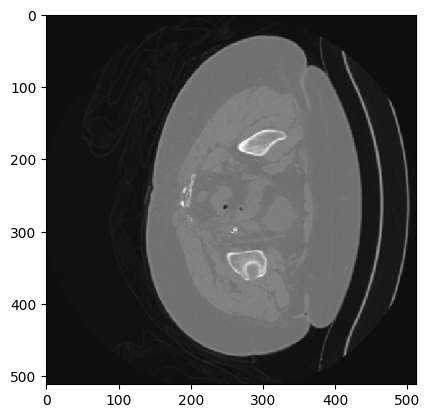

In [67]:
plt.imshow(data_train[0], cmap="gray")

In [38]:
_, imgthreshold = cv.threshold(data_train[0], 115, 255, cv.THRESH_BINARY)

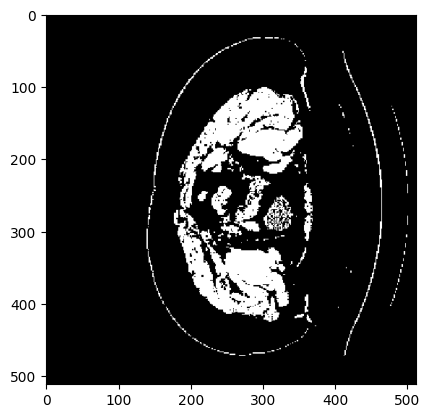

In [39]:
plt.imshow(imgthreshold, cmap="gray")

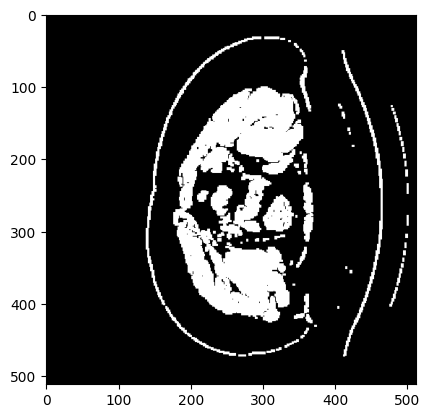

In [42]:
# Dilation
kernel = np.ones((3,3),np.uint8)
dilate = cv.morphologyEx(imgthreshold, cv.MORPH_DILATE, kernel)
plt.imshow(dilate, cmap="gray")

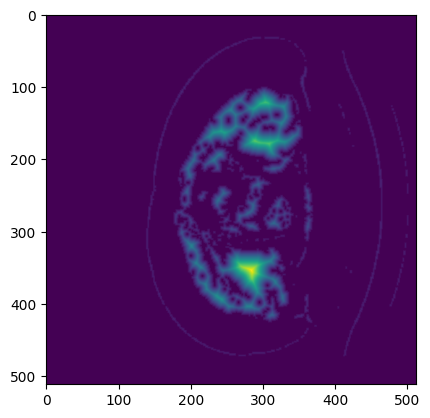

In [46]:
#DistTrans
#check distance between white pixels and black pixels
distance = cv.distanceTransform(dilate, cv.DIST_L2, 0)
plt.imshow(distance)

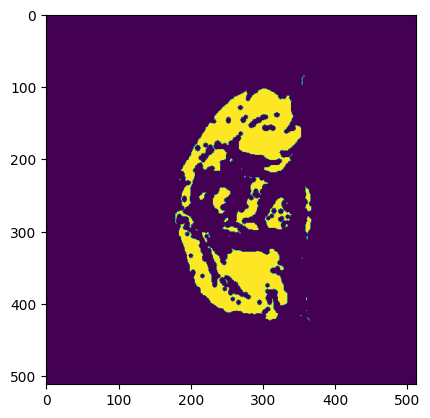

In [59]:
_,distance_threshold = cv.threshold(distance, 3, 255, cv.THRESH_BINARY)
plt.imshow(distance_threshold)

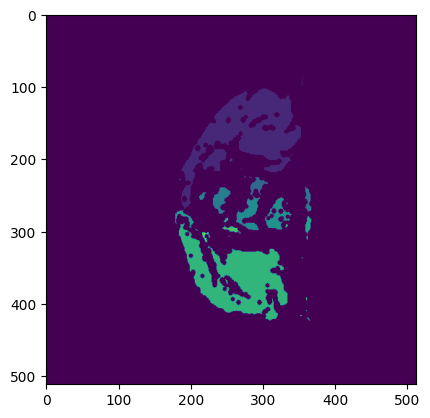

In [63]:
distance_threshold = np.uint8(distance_threshold)
_, labels = cv.connectedComponents(distance_threshold)
plt.imshow(labels)

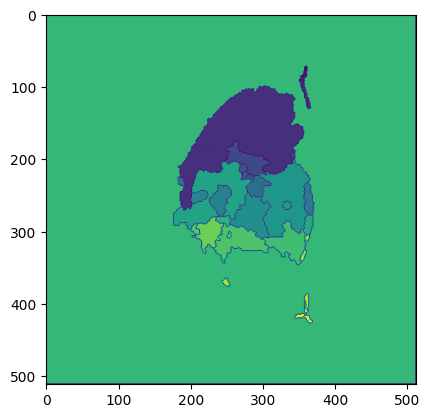

In [72]:
image = cv2.normalize(data_train[0], None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
labels = np.int32(labels)
labels = cv.watershed(image, labels)
plt.imshow(labels)

## Scoring Watershed

In [87]:
def compute_baseline_one_sample(data_slice):
    _, imgthreshold = cv.threshold(data_slice, 115, 255, cv.THRESH_BINARY)
    distance = cv.distanceTransform(imgthreshold, cv.DIST_L2, 0)
    _,distance_threshold = cv.threshold(distance, 3, 255, cv.THRESH_BINARY)
    distance_threshold = np.uint8(distance_threshold)
    _, labels = cv.connectedComponents(distance_threshold)
    image = cv2.normalize(data_train[0], None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    labels = np.int32(labels)
    labels = cv.watershed(image, labels)
    return labels



def compute_baseline(dataset: np.array):
    labels_predicted_list = []
    for data_index in tqdm(range(len(dataset))):
        data_slice = dataset[data_index]
        label_predicted = alternative_watershed(data_slice)
        labels_predicted_list.append(label_predicted)
    return pd.DataFrame(np.stack(labels_predicted_list, axis=0)\
                        .reshape((len(labels_predicted_list), -1)))

# Let's create a validation set first: the 200 first images of the train set
data_val = data_train[:200]
labels_val = labels_train.iloc[:200]

labels_val_predicted_baseline = compute_baseline(data_val)


def rand_index_dataset(y_true_df: pd.DataFrame, y_pred_df: pd.DataFrame) -> float:
    """Compute the individual rand index for each sample in the dataset and then average it"""
    individual_rand_index = []
    for row_index in range(y_true_df.values.shape[0]):
        labels = y_true_df.values[row_index]
        preds = y_pred_df.values[row_index]
        individual_rand_index.append(sklearn.metrics.adjusted_rand_score(labels, preds))

    return np.mean(individual_rand_index)

  0%|                                                   | 0/200 [00:00<?, ?it/s]/var/folders/r6/_n5q4xzd5wb5ljrrd2cjsnyh0000gn/T/ipykernel_47570/1628403037.py:16: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(gradient, indices=False, footprint=np.ones((3, 3)), labels=image)
100%|█████████████████████████████████████████| 200/200 [07:06<00:00,  2.13s/it]


In [88]:
rand_index_dataset(labels_val, labels_val_predicted_baseline)


0.009547019189820151

## ChatGPT Watershed

In [86]:
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage as ndi
from skimage.filters import gaussian
import numpy as np


def alternative_watershed(image):
    # Apply Gaussian blur for smoothing
    blurred_image = gaussian(image, sigma=1)

    # Compute the gradient (using Scharr)
    gradient = scharr(blurred_image)

    # Generate markers based on local maxima
    local_maxi = peak_local_max(gradient, indices=False, footprint=np.ones((3, 3)), labels=image)
    markers = ndi.label(local_maxi)[0]

    # Apply watershed segmentation
    labels = watershed(-gradient, markers, mask=image)

    return labels

# Organ Segmentation

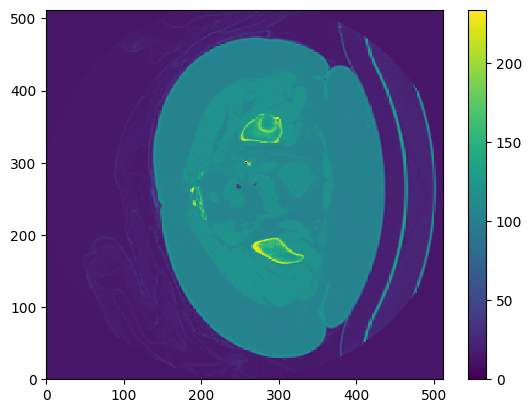

In [75]:
plt.pcolormesh(data_train[0])
plt.colorbar()

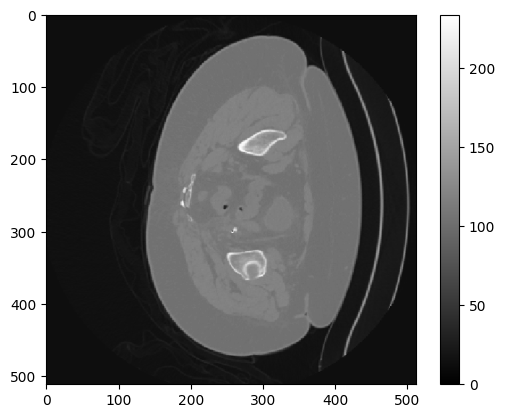

In [78]:
plt.imshow(data_train[0], cmap = 'gray')
plt.colorbar()